# Overview (CSV-only)

This notebook presents a general overview of graph data **from pre-generated CSV files** (no live Neo4j connection).

It visualizes node labels, relationship types, and per-artifact package/type counts, and computes overall graph density when totals are available.

This version includes:
- Cleaner **pie charts** (Top-N + donut + central total),
- Robust **artifact/value column detection**, numeric coercion, and NaN filtering for bar charts,
- Optional **Plotly** interactivity with automatic fallback to matplotlib.

## Expected CSV location
Relative to this notebook (assumed in `<repo>/jupyter/`), data is read from `<repo>/reports/overview-csv/`.

In [1]:
# --- Paths & CSV helpers (pathlib + diagnostics) ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent  # assuming this notebook lives in <repo>/jupyter/
OVERVIEW_DIR = ROOT / "reports" / "overview-csv"

print("OVERVIEW_DIR ->", OVERVIEW_DIR.resolve())
print("CSV files in overview-csv/:")
for p in sorted(OVERVIEW_DIR.glob("*.csv")):
    print(" -", p.name)

def read_csv_or_empty(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"[warn] Missing CSV: {path.name}")
        return pd.DataFrame()
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception as e:
        print(f"[warn] Failed to read CSV: {path.name} -> {e}")
        return pd.DataFrame()

# Known files from your layout
df_node_label_count          = read_csv_or_empty(OVERVIEW_DIR / "NodeLabelCount.csv")
df_rel_type_count            = read_csv_or_empty(OVERVIEW_DIR / "RelationshipTypeCount.csv")
df_labels_and_relationships  = read_csv_or_empty(OVERVIEW_DIR / "NodeLabelsAndRelationships.csv")
df_overview_size             = read_csv_or_empty(OVERVIEW_DIR / "OverviewSize.csv")
df_packages_per_artifact     = read_csv_or_empty(OVERVIEW_DIR / "NumberOfPackagesPerArtifact.csv")
df_types_per_artifact        = read_csv_or_empty(OVERVIEW_DIR / "NumberOfTypesPerArtifact.csv")

print("Shapes:",
      "labels", df_node_label_count.shape,
      "rels", df_rel_type_count.shape,
      "labels+rels", df_labels_and_relationships.shape,
      "size", df_overview_size.shape,
      "packages", df_packages_per_artifact.shape,
      "types", df_types_per_artifact.shape)


OVERVIEW_DIR -> /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/overview-csv
CSV files in overview-csv/:
 - NodeLabelCount.csv
 - NodeLabelsAndRelationships.csv
 - NumberOfPackagesPerArtifact.csv
 - NumberOfTypesPerArtifact.csv
 - OverviewSize.csv
 - RelationshipTypeCount.csv
Shapes: labels (74, 4) rels (74, 4) labels+rels (578, 8) size (1, 8) packages (301, 3) types (301, 3)


In [2]:
# --- Column helpers & numeric coercion ---
from typing import List, Optional

def pick_first(df: pd.DataFrame, candidates: List[str], kind: Optional[str]=None) -> Optional[str]:
    """
    Pick the first suitable column.
    - kind=None: choose the first matching name in 'candidates'.
    - kind='numeric': choose the first numeric column.
    - kind='text': choose the first non-numeric column.
    """
    if df.empty:
        return None
    if kind is None:
        for c in candidates:
            if c in df.columns:
                return c
        return None
    elif kind == "numeric":
        for c in df.columns:
            if pd.api.types.is_numeric_dtype(df[c]):
                return c
        return None
    elif kind == "text":
        for c in df.columns:
            if not pd.api.types.is_numeric_dtype(df[c]):
                return c
        return None
    return None

def to_numeric_safe(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors="coerce")

def find_artifact_col(df: pd.DataFrame) -> Optional[str]:
    prefs = [
        "artifact.fileName", "artifactFileName", "artifact_path",
        "artifact", "fileName", "filename", "name", "artifactName"
    ]
    for c in prefs:
        if c in df.columns:
            return c
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]) and df[c].notna().sum() >= 2:
            return c
    return None

def find_numeric_col(df: pd.DataFrame, preferred: List[str]) -> Optional[str]:
    for c in preferred:
        if c in df.columns:
            return c
    for c in df.columns:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().sum() >= 1:
            return c
    return None

def ensure_percent(df: pd.DataFrame, value_col: str, percent_col: Optional[str]=None) -> pd.DataFrame:
    out = df.copy()
    if percent_col is None:
        percent_col = f"{value_col}Percent"
    total = to_numeric_safe(out[value_col]).sum()
    out[value_col] = to_numeric_safe(out[value_col]).fillna(0)
    out[percent_col] = 0.0 if total == 0 else (out[value_col] / total) * 100.0
    return out

def group_small_as_others(df: pd.DataFrame, name_col: str, value_col: str, threshold_pct: float) -> pd.DataFrame:
    tmp = ensure_percent(df[[name_col, value_col]], value_col)
    pcol = f"{value_col}Percent"
    tmp[name_col] = tmp[name_col].astype(str)
    tmp.loc[tmp[pcol] < threshold_pct, name_col] = "others"
    return tmp.groupby(name_col, as_index=True).sum().sort_values(by=pcol, ascending=False)


In [3]:
# --- Donut pie with Top-N + central total ---
def pie_with_others_clean(df: pd.DataFrame, name_col: str, value_col: str, top_n: int = 8, title: str = "", others_label: str = "others"):
    if df.empty or name_col not in df.columns or value_col not in df.columns:
        print(f"[info] Missing columns for pie '{title}'")
        return

    work = df[[name_col, value_col]].copy()
    work[name_col] = work[name_col].astype(str)
    work[value_col] = to_numeric_safe(work[value_col]).fillna(0)
    work = work.sort_values(value_col, ascending=False)

    top = work.head(top_n).copy()
    if len(work) > top_n:
        others_sum = work.iloc[top_n:][value_col].sum()
        top = pd.concat([top, pd.DataFrame({name_col: [others_label], value_col: [others_sum]})], ignore_index=True)

    total = int(top[value_col].sum())

    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(
        top[value_col],
        labels=top[name_col],
        autopct=lambda pct: f"{pct:.1f}% ({int(total * pct/100)})" if pct >= 3 else "",
        pctdistance=0.8,
        labeldistance=1.05,
        wedgeprops=dict(width=0.4),  # donut style
        startangle=90
    )
    ax.text(0, 0, f"Total\n{total:,}", ha="center", va="center", fontsize=11)
    ax.set_title(title, pad=12)
    plt.legend(wedges, top[name_col], bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=8)
    plt.tight_layout()
    plt.show()


In [4]:
# --- Optional Plotly bar with fallback to matplotlib ---
try:
    import plotly.express as px
    HAS_PLOTLY = True
except Exception:
    HAS_PLOTLY = False

def bar_smart_clean(df: pd.DataFrame, name_col: str, value_col: str, title: str, ylabel: str, top_n: int = 20):
    if df.empty or name_col not in df.columns or value_col not in df.columns:
        print(f"[info] Missing columns for '{title}'")
        return
    sub = df[[name_col, value_col]].copy()
    sub[name_col] = sub[name_col].astype(str)
    sub[value_col] = to_numeric_safe(sub[value_col])
    sub = sub.dropna(subset=[name_col, value_col])
    sub = sub[sub[name_col].str.strip().ne("")]
    if sub.empty:
        print(f"[info] No rows to plot in '{title}' after cleaning.")
        return
    sub = sub.sort_values(value_col, ascending=False).head(top_n)
    display(sub)
    if HAS_PLOTLY:
        fig = px.bar(sub, x=name_col, y=value_col, title=title, labels={name_col: "", value_col: ylabel})
        fig.update_layout(xaxis_tickangle=-60, height=450, margin=dict(l=20, r=20, t=60, b=40))
        fig.show()
    else:
        plt.figure(figsize=(10, 5))
        plt.bar(sub[name_col], sub[value_col])
        plt.xticks(rotation=60, ha="right")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        plt.show()


In [5]:
# --- Totals & density (prefer OverviewSize; avoid double-counting) ---
total_nodes = None
total_relationships = None

# Try OverviewSize.csv
if not df_overview_size.empty:
    node_cands = [c for c in df_overview_size.columns if "node" in c.lower()]
    rel_cands  = [c for c in df_overview_size.columns if "rel" in c.lower() or "relationship" in c.lower()]
    for c in node_cands:
        if pd.api.types.is_numeric_dtype(df_overview_size[c]):
            total_nodes = int(df_overview_size[c].iloc[0])
            break
    for c in rel_cands:
        if pd.api.types.is_numeric_dtype(df_overview_size[c]):
            total_relationships = int(df_overview_size[c].iloc[0])
            break

# Fallback for relationships: sum of RelationshipTypeCount
if total_relationships is None and not df_rel_type_count.empty:
    rc = pick_first(df_rel_type_count, ["nodesWithThatRelationshipType", "count"], kind=None) or \
         pick_first(df_rel_type_count, [], kind="numeric")
    if rc:
        total_relationships = int(pd.to_numeric(df_rel_type_count[rc], errors="coerce").sum())

print("total_number_of_nodes (vertices):", total_nodes)
print("total_number_of_relationships (edges):", total_relationships)

if total_nodes and total_nodes > 1 and total_relationships is not None:
    dens = total_relationships / (total_nodes * (total_nodes - 1))
    print("-> total directed graph density:", dens)
    print("-> total directed graph density in percent:", dens * 100)
else:
    print("[info] Not enough data to compute density reliably.")


total_number_of_nodes (vertices): 3654271
total_number_of_relationships (edges): 13919949
-> total directed graph density: 1.042404458273415e-06
-> total directed graph density in percent: 0.00010424044582734151


In [6]:
# --- Node labels: Top 20 ---
if not df_node_label_count.empty:
    label_col = pick_first(df_node_label_count, ["nodeLabel"], None) or pick_first(df_node_label_count, [], "text")
    count_col = pick_first(df_node_label_count, ["nodesWithThatLabel"], None) or pick_first(df_node_label_count, [], "numeric")
    top = df_node_label_count.sort_values(count_col, ascending=False).head(20)
    display(top)
    bar_smart_clean(top, label_col, count_col, "Top 20 node labels by count", "nodes")
else:
    print("[info] NodeLabelCount.csv not found or empty.")


,nodeLabel,nodesWithThatLabel,nodesWithThatLabelPercent,Source Cypher File: Overview/Node_label_count.cypher
0,Java,3252187,88.996875,NaN
1,ByteCode,3242983,88.745006,NaN
2,Member,1448193,39.630148,NaN
3,Method,1113223,30.463614,NaN
4,Parameter,860210,23.539852,NaN
5,Bound,582685,15.945314,NaN
6,Field,334970,9.166534,NaN
7,Xml,289757,7.929270,NaN
8,Value,273518,7.484885,NaN
9,ParameterizedType,192011,5.254427,NaN


,nodeLabel,nodesWithThatLabel
0,Java,3252187
1,ByteCode,3242983
2,Member,1448193
3,Method,1113223
4,Parameter,860210
5,Bound,582685
6,Field,334970
7,Xml,289757
8,Value,273518
9,ParameterizedType,192011


,relationshipType,nodesWithThatRelationshipType,nodesWithThatRelationshipTypePercent,Source Cypher File: Overview/Relationship_type_count.cypher
0,INVOKES,3094986,22.234176,NaN
1,DECLARES,1488648,10.694350,NaN
2,OF_TYPE,1473110,10.582726,NaN
3,DEPENDS_ON,1383899,9.941840,NaN
4,READS,1197812,8.605003,NaN
5,HAS,1000532,7.187756,NaN
6,RETURNS,908690,6.527969,NaN
7,OF_RAW_TYPE,564554,4.055719,NaN
8,WRITES,410412,2.948373,NaN
9,THROWS,301314,2.164620,NaN


,relationshipType,nodesWithThatRelationshipType
0,INVOKES,3094986
1,DECLARES,1488648
2,OF_TYPE,1473110
3,DEPENDS_ON,1383899
4,READS,1197812
5,HAS,1000532
6,RETURNS,908690
7,OF_RAW_TYPE,564554
8,WRITES,410412
9,THROWS,301314


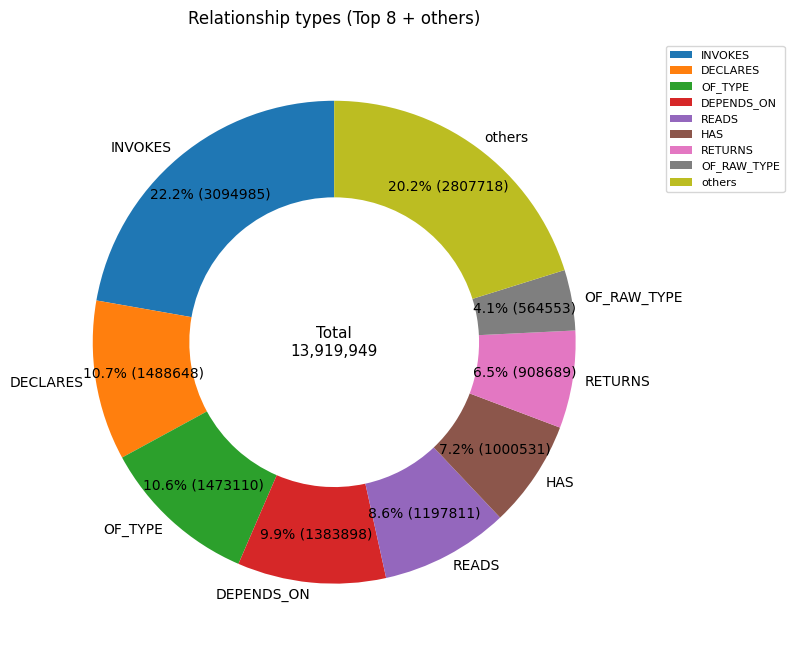

In [7]:
# --- Relationship types: Top 20 + Donut (Top-8 + others) ---
if not df_rel_type_count.empty:
    type_col  = pick_first(df_rel_type_count, ["relationshipType"], None) or pick_first(df_rel_type_count, [], "text")
    count_col = pick_first(df_rel_type_count, ["nodesWithThatRelationshipType"], None) or pick_first(df_rel_type_count, [], "numeric")
    top = df_rel_type_count.sort_values(count_col, ascending=False).head(20)
    display(top)
    bar_smart_clean(top, type_col, count_col, "Top 20 relationship types by count", "relationships")
    pie_with_others_clean(df_rel_type_count, type_col, count_col, top_n=8, title="Relationship types (Top 8 + others)")
else:
    print("[info] RelationshipTypeCount.csv not found or empty.")


In [8]:
# --- Packages per artifact (Top 20) ---
if not df_packages_per_artifact.empty:
    a = find_artifact_col(df_packages_per_artifact)
    v = find_numeric_col(df_packages_per_artifact, preferred=["numberOfPackages", "packages", "count", "value"])
    print("Detected columns (packages):", a, v)
    bar_smart_clean(df_packages_per_artifact, a, v, "Packages per artifact (Top 20)", "#packages", top_n=20)
else:
    print("[info] NumberOfPackagesPerArtifact.csv not found or empty.")


Detected columns (packages): artifactName numberOfPackages


,artifactName,numberOfPackages
0,/BOOT-INF/lib/ehcache-2.10.9.2.jar,520
1,/BOOT-INF/lib/hibernate-core-5.4.33.jar,342
2,/BOOT-INF/lib/opensearch-2.2.0.jar,335
3,/BOOT-INF/lib/infinispan-core-9.4.18.Final.jar,177
4,/BOOT-INF/lib/xmlbeans-2.6.0.jar,153
5,/shopizer.jar,139
6,/BOOT-INF/lib/sm-core-3.2.5.jar,136
7,/BOOT-INF/lib/poi-ooxml-schemas-3.17.jar,114
8,/BOOT-INF/lib/spring-boot-autoconfigure-2.5.12...,110
9,/BOOT-INF/lib/spring-boot-actuator-autoconfigu...,100


In [9]:
# --- Types per artifact (Top 20) ---
if not df_types_per_artifact.empty:
    a = find_artifact_col(df_types_per_artifact)
    v = find_numeric_col(df_types_per_artifact, preferred=["numberOfTypes", "types", "count", "value"])
    print("Detected columns (types):", a, v)
    bar_smart_clean(df_types_per_artifact, a, v, "Types per artifact (Top 20)", "#types", top_n=20)
else:
    print("[info] NumberOfTypesPerArtifact.csv not found or empty.")


Detected columns (types): artifactName numberOfTypes


,artifactName,numberOfTypes
0,/BOOT-INF/lib/opensearch-2.2.0.jar,6536
1,/BOOT-INF/lib/hibernate-core-5.4.33.jar,4800
2,/BOOT-INF/lib/poi-ooxml-schemas-3.17.jar,2579
3,/BOOT-INF/lib/infinispan-core-9.4.18.Final.jar,2544
4,/BOOT-INF/lib/byte-buddy-1.10.22.jar,2459
5,/BOOT-INF/lib/lucene-core-9.3.0.jar,2117
6,/BOOT-INF/lib/drools-core-7.32.0.Final.jar,2091
7,/BOOT-INF/lib/stripe-java-19.5.0.jar,2081
8,/BOOT-INF/lib/guava-27.1-jre.jar,1950
9,/BOOT-INF/lib/poi-3.17.jar,1715


In [10]:
# --- Node labels with their relationships (Top 30 rows) ---
if not df_labels_and_relationships.empty:
    display(df_labels_and_relationships.head(30))
else:
    print("[info] NodeLabelsAndRelationships.csv not found or empty.")


,sourceLabels,relationType,targetLabels,numberOfRelationships,numberOfNodesWithSameLabelsAsSource,numberOfNodesWithSameLabelsAsTarget,densityInPercent,Source Cypher File: Overview/Node_labels_and_their_relationships.cypher
0,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Method",2405927,952879,952879,0.000265,NaN
1,"Java,ByteCode,Member,Method",READS,"Java,ByteCode,Member,Field",1146692,952879,334970,0.000359,NaN
2,"Java,ByteCode,Member,Method",HAS,"Java,ByteCode,Parameter",661222,952879,860210,0.000081,NaN
3,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Method",649203,66098,952879,0.001031,NaN
4,"Java,ByteCode,Parameter",OF_TYPE,"Type,File,Java,ByteCode",595207,860210,50408,0.001373,NaN
5,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,ByteCode",556876,66098,50408,0.016714,NaN
6,"Java,ByteCode,Member,Method",RETURNS,"Type,File,Java,ByteCode",543346,952879,50408,0.001131,NaN
7,"Java,ByteCode,Member,Method",INVOKES,"Java,ByteCode,Member,Constructor,Method",320795,952879,138666,0.000243,NaN
8,"Type,File,Java,Class,ByteCode",DEPENDS_ON,"Type,File,Java,Class,ByteCode",275001,66098,66098,0.006294,NaN
9,"Type,File,Java,Class,ByteCode",DECLARES,"Java,ByteCode,Member,Field",254968,66098,334970,0.001152,NaN


In [11]:
# --- Compact table CSS for nicer HTML/PDF export ---
from IPython.display import HTML, display
display(HTML(
    """
    <style>
    .dataframe th { font-size: 10px; }
    .dataframe td { font-size: 10px; }
    </style>
    """
))
